## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [89]:
import kaggle
import os
import pickle
import subprocess
import torch
import torchvision
# import tqdm


import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from collections import Counter
from IPython.display import (Image, clear_output)
from pathlib import Path
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch import nn
from torch.utils.data import (Dataset, DataLoader)
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import transforms

In [3]:
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda:0


## requirements.txt

In [4]:
!pip list --format=freeze > requirements.txt

## Download dataset

### Windows

In [ ]:
%%cmd  # Windows 10 Pro 22H2, Miniforge3-23.3.1-1.4.2., Miniforge Prompt
set path_kaggle="D:\Users\d2707\Documents\Colab Notebooks\Курсы\Институт биоинформатики\Семестр 2\ML\Проект\data_folder\raw_data"
kaggle config set -n path -v %path_kaggle%
kaggle competitions download -c aptos2019-blindness-detection
cd "%path_kaggle%\competitions\aptos2019-blindness-detection" && dir

# 01.05.2024  15:16    <DIR>          .
# 01.05.2024  15:16    <DIR>          ..
# 18.12.2019  03:48    10 215 289 875 aptos2019-blindness-detection.zip

In [ ]:
%%cmd  # Windows 10 Pro 22H2, Miniforge3-23.3.1-1.4.2., Miniforge Prompt
tar -xf aptos2019-blindness-detection.zip && del aptos2019-blindness-detection.zip
dir

# 01.05.2024  15:37    <DIR>          .
# 01.05.2024  15:37    <DIR>          ..
# 18.12.2019  03:23            28 938 sample_submission.csv
# 18.12.2019  03:23            25 072 test.csv
# 01.05.2024  15:34    <DIR>          test_images
# 18.12.2019  03:27            54 948 train.csv
# 01.05.2024  15:35    <DIR>          train_images

In [4]:
%cd "..\data_folder\raw_data\competitions\aptos2019-blindness-detection"

d:\Users\d2707\Documents\Colab Notebooks\Курсы\Институт биоинформатики\Семестр 2\ML\Проект\data_folder\raw_data\competitions\aptos2019-blindness-detection


### UNIX

In [ ]:
%%bash
path_kaggle="/mnt/d/Users/d2707/Documents/Colab Notebooks/Курсы/Институт биоинформатики/Семестр 2/ML/Проект/data_folder/raw_data"
kaggle config set -n path -v $path_kaggle
kaggle competitions download -c aptos2019-blindness-detection && ls
cd $path_kaggle/competitions/aptos2019-blindness-detection && ls


In [ ]:
%%bash
unzip aptos2019-blindness-detection.zip && rm aptos2019-blindness-detection.zip
ls
# sample_submission.csv  test.csv  test_images  train.csv  train_images

%cd "../data_folder/raw_data/competitions/aptos2019-blindness-detection"

### Google colab

!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c aptos2019-blindness-detection

In [ ]:
!unzip aptos2019-blindness-detection.zip && rm aptos2019-blindness-detection.zip

In [ ]:
!ls

## Ознакомимся с датасетом

In [5]:
train_folder_path = "./train_images"
test_folder_path = "./test_images"

In [6]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [7]:
diagnosis_codes = {
    0: 'No diabetic retinopathy',
    1: 'Mild diabetic retinopathy',
    2: 'Moderate diabetic retinopathy',
    3: 'Severe diabetic retinopathy',
    4: 'Proliferative diabetic retinopathy'
}

In [8]:
train_df.head()

id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

### Визуализируем примеры классов

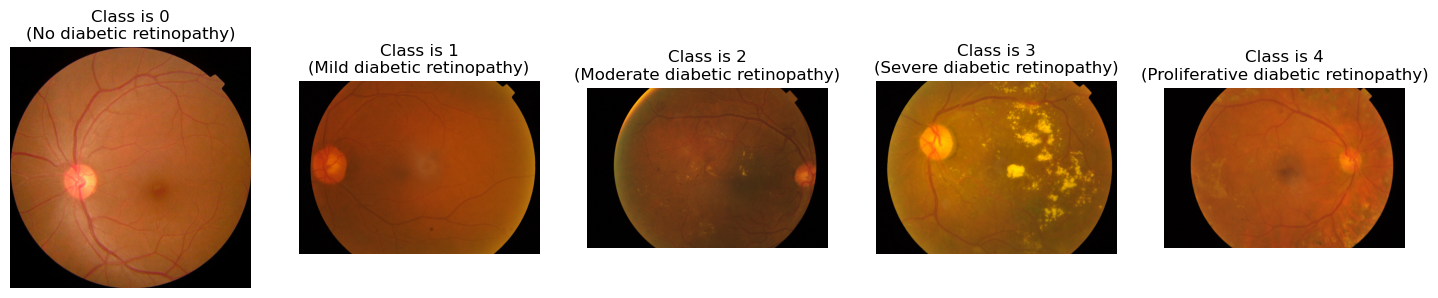

In [9]:
n_classes = train_df.diagnosis.nunique()
class_set = set()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(18, 8))

for image in train_df.iterrows():
    if len(class_set) == n_classes:
        break
    id_code, diagnosis = image[1]
    if diagnosis in class_set:
        continue
    class_set.add(diagnosis)
    image_path = os.path.join(train_folder_path, f"{id_code}.png")

    image = mpimg.imread(image_path)
    plt.subplot(1, 5, diagnosis + 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Class is {diagnosis}\n({diagnosis_codes[diagnosis]})", fontsize=12);

### Визуализируем случайную картинку

In [12]:
import random
import time

def drag_random_image(diagnosis_code,
                      *,
                      seed=None,
                      diagnosis_codes={},
                      folder_path = './train_images',
                      if_show=False):

    if not diagnosis_codes:
        diagnosis_codes = {
            0: 'No diabetic retinopathy',
            1: 'Mild diabetic retinopathy',
            2: 'Moderate diabetic retinopathy',
            3: 'Severe diabetic retinopathy',
            4: 'Proliferative diabetic retinopathy'
            }

    if seed is None:
        seed = time.time()

    random.seed(seed)
    img_list = train_df.query('diagnosis == @diagnosis_code').id_code.values
    img_path = os.path.join(folder_path, f"{random.choice(img_list)}.png")
    img = Image.open(img_path)
    if if_show:
        plt.imshow(img)
        plt.axis("off")
        plt.title(f'Class is {diagnosis_code}\n({diagnosis_codes[diagnosis_code]})', fontsize=14);
    if not if_show:
        return img

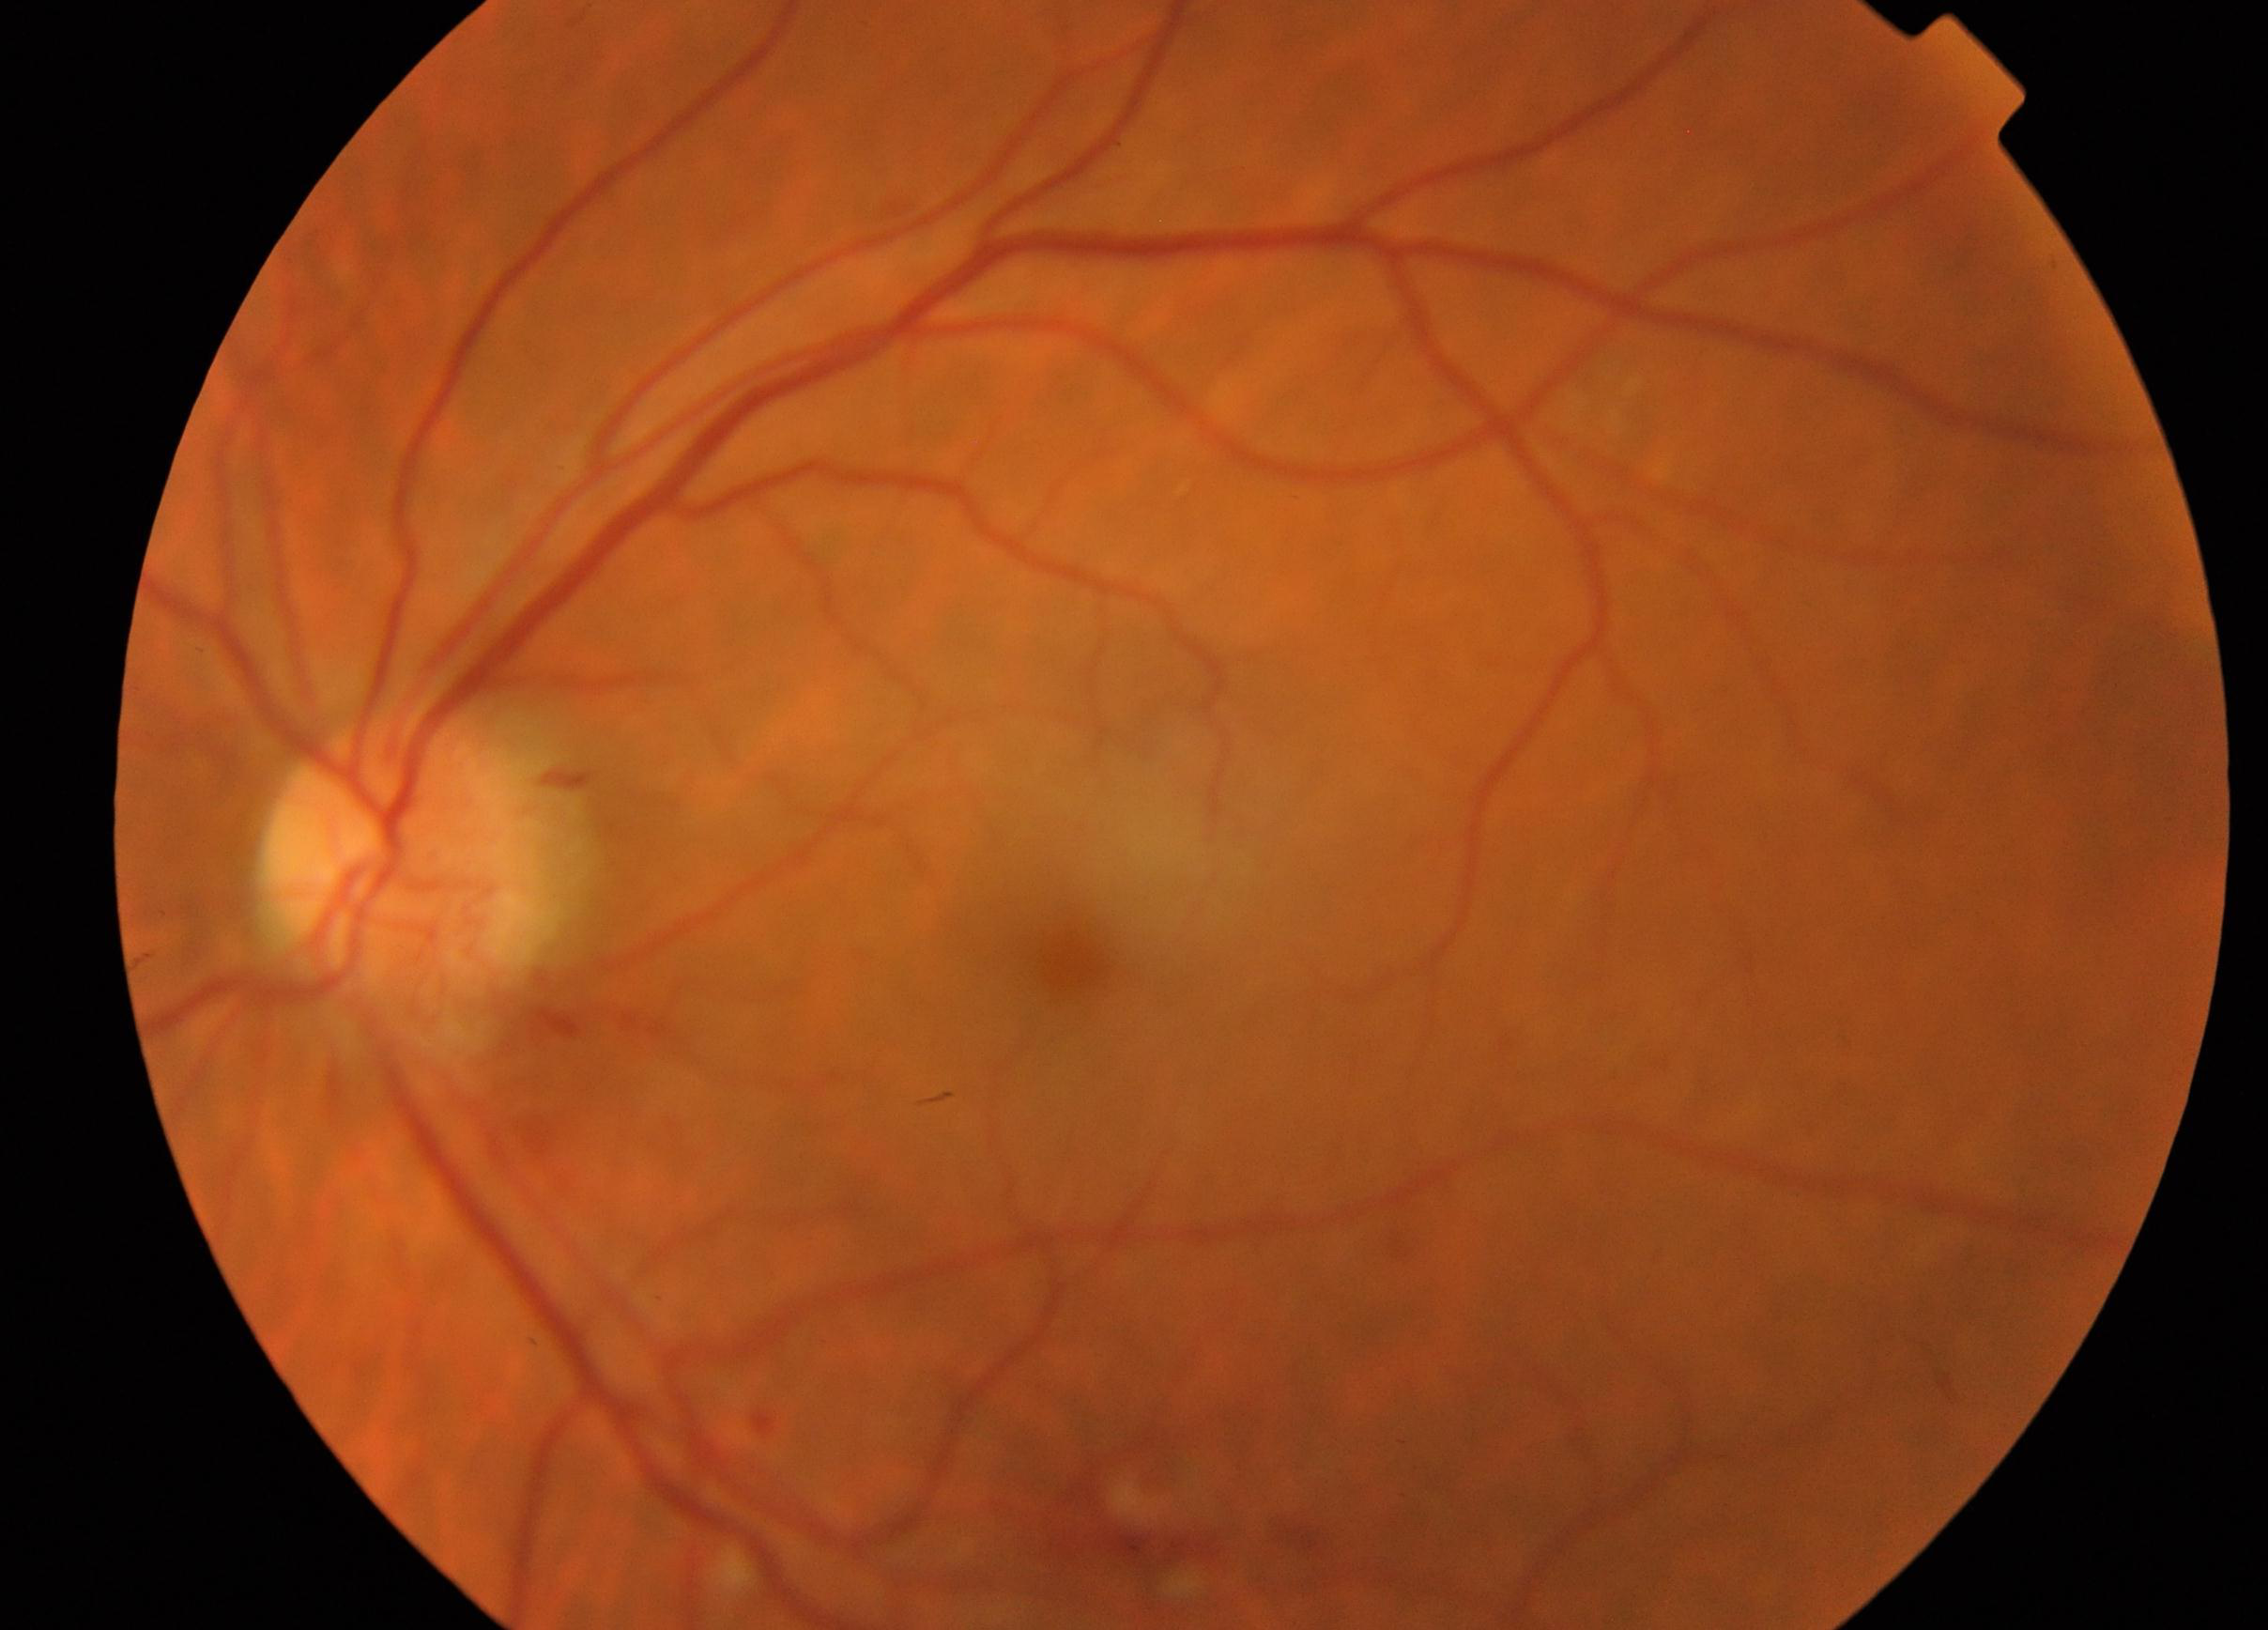

In [47]:
drag_random_image(4)

## Прочтём датасет

### Прочтём данные и разобъём на `train` и `test`

In [20]:
train_val_files = sorted(list(Path(train_folder_path).rglob("*.png")))
train_val_labels = train_df.sort_values(by='id_code').diagnosis.values
# files_stem_list = [file.stem for file in train_val_files]
# train_val_labels = train_df[train_df.id_code.isin(files_stem_list)].sort_values(by='id_code').diagnosis.values

train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [21]:
(N_CLASSES := len(set(train_val_labels)))

5

### Оценим баланс классов

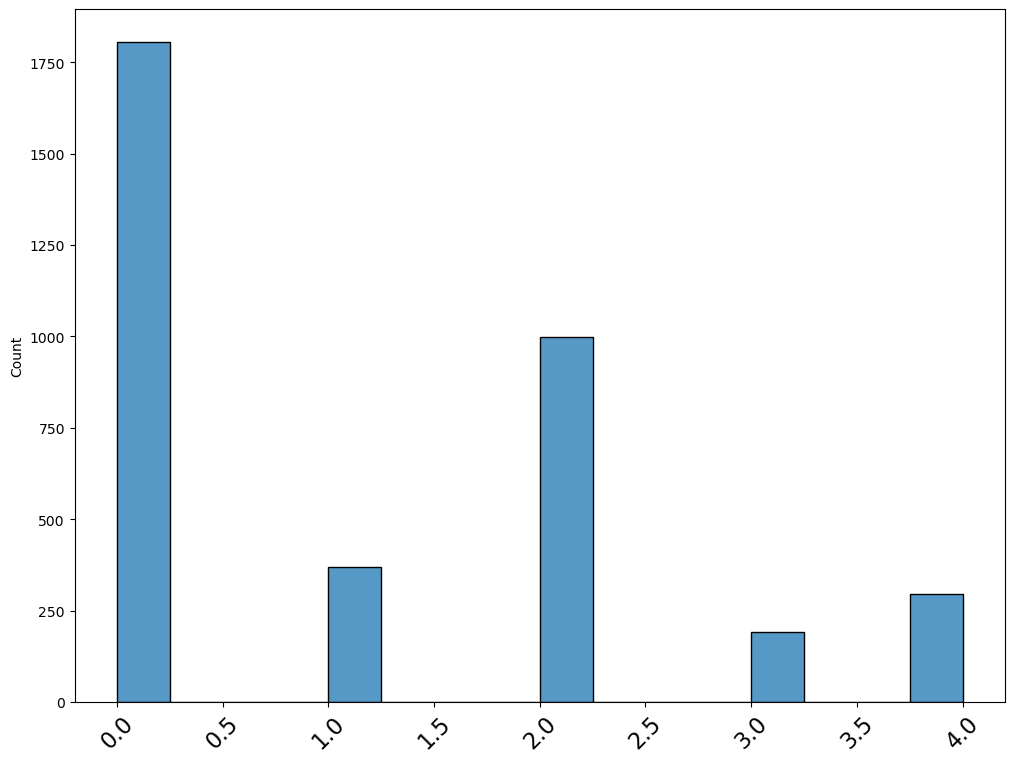

In [22]:
plt.figure(figsize=(12, 9))
sns.histplot(train_val_labels)
plt.xticks(rotation=45, fontsize=16);

### Класс датасета для `Dataloader`

In [191]:
class OcularDataset(Dataset):
    def __init__(self,
                 files,
                 path_to_labels,
                 preprocess,
                 mode="train"
                 ) -> None:
        '''
        files - список с файлами вв виде объектов Path
        path_to_labels - путь к csv-файлу с классами
        '''
        super().__init__()
        # Сортируем файлы, чтобы они всегда были в одном
        # и том же порядке
        self.files = sorted(files)
        # Записываем количество
        self.len_ = len(self.files)
        self.labels = path_to_labels
        self.preprocess = preprocess
        self.mode = mode
        self.sampler = WeightedRandomSampler

    @property
    def labels(self):
        return self._labels

    @labels.setter
    def labels(self, path_to_labels):
        labels_df = pd.read_csv(path_to_labels)
        files_stem_list = [file.stem for file in self.files]
        self._labels = labels_df[labels_df.id_code.isin(files_stem_list)].sort_values(by='id_code').diagnosis.values

    def __len__(self):
        return self.len_

    @property
    def sampler(self):
        return self._sampler

    # https://marekpaulik.medium.com/imbalanced-dataset-image-classification-with-pytorch-6de864982eb1
    @sampler.setter
    def sampler(self, sampler):
        class_count = Counter(self.labels)
        # Can't iterate over class_count because dictionary is unordered
        class_weights = torch.Tensor([len(self.labels)/c for c in pd.Series(class_count).sort_index().values])

        sample_weights = np.zeros(len(self.labels))
        for idx, label in enumerate(self.labels):
            sample_weights[idx] = class_weights[label]
        
        self._sampler = sampler(weights=torch.DoubleTensor(sample_weights),
                                num_samples=len(sample_weights),
                                replacement=True)

    def load_sample(self, file):
      """
      Загружаем картинки из файлов
      """
      image = Image.open(file)
      image.load()
      return image

    def __getitem__(self, index):
      """
      По индексу достаем картинку и лэйбл
      """
      # загружаем картинку
      # https://pytorch.org/hub/pytorch_vision_googlenet/
      input_image = Image.open(self.files[index])
      transform = transforms.Compose([
                      transforms.Resize(size=self.preprocess['RESCALE_SIZE'][0]),
                      transforms.CenterCrop(size=self.preprocess['RESCALE_SIZE'][1]),
                      transforms.ToTensor(),
                      transforms.Normalize(mean=self.preprocess['mean'], std=self.preprocess['std'])
                      ])

      x = transform(input_image)
      y = self.labels[index]

      return x, y

### Загрузим данные с помощью `Dataloader`

In [192]:
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PREPROCESS={
    'RESCALE_SIZE': (256, 224),
    'mean': [0.4064, 0.2169, 0.0722], 
    'std': [0.2786, 0.1515, 0.0811]
    }

print(f"Using device: {DEVICE}")

Using device: cuda


In [193]:
trainset = OcularDataset(train_files, path_to_labels='./train.csv', preprocess=PREPROCESS)
valset = OcularDataset(val_files, path_to_labels='./train.csv', preprocess=PREPROCESS, mode="val")

In [194]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, sampler=trainset.sampler)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False)

### Пример для отладки

In [68]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
model.eval()

Using cache found in C:\Users\d2707/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\d2707\miniforge3\envs\BI-ML-2024_3.12\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\d2707\miniforge3\envs\BI-ML-2024_3.12\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [123]:
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [124]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over ImageNet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)


tensor([ 3.5608e-02, -2.2878e-01, -3.2326e-01,  5.5473e-02,  1.1363e-01,
        -2.8251e-01,  6.1544e-01,  6.0953e-02,  9.4566e-01, -1.4981e+00,
        -5.5102e-01, -3.6589e-02, -1.2635e+00, -3.1757e-02,  5.3338e-01,
         1.8749e-01,  4.9309e-01, -2.8286e-01, -2.7196e-01, -2.6181e-01,
        -3.3155e-01, -7.5721e-02,  6.7103e-02, -5.7090e-01, -5.3175e-01,
        -4.9966e-02,  7.2163e-01,  1.1626e+00,  5.1519e-01,  1.3022e+00,
         6.9073e-01,  5.5678e-01,  1.3273e-01, -7.1238e-01, -5.0567e-01,
        -2.4467e-01, -5.9905e-01,  1.9404e-01, -3.2087e-01,  6.1736e-01,
         2.9624e-01, -2.4294e-01,  1.8518e-01, -4.5889e-01,  1.5296e-01,
        -6.8361e-01,  9.9018e-01,  6.1653e-01, -1.2935e+00, -4.6650e-01,
        -7.1417e-02, -3.4094e-04,  3.7411e-01,  1.8117e-01,  8.5821e-01,
         1.0058e+00, -3.0185e-01,  1.9625e-02,  7.9076e-02,  8.1202e-01,
         7.7451e-01, -7.0558e-01, -2.2717e-01, -2.5871e-01,  1.5508e-01,
        -4.5723e-01,  7.8180e-01,  1.4157e-01,  1.0

### Класс для тренировки и валидации моделей

In [195]:
class Trainer:
    def __init__(self, model, epochs, criterion,
                 optimizer, trainloader,
                 validloader, device, metric,
                 validate=True, scheduler=None,
                 verbose=2):
        self.model = model.to(device)
        self.epochs = epochs
        self.criterion = criterion
        self.optimizer = optimizer
        self.trainloader = trainloader
        self.validloader = validloader
        self.device = device
        self.metric = metric
        self.validate = validate
        self.verbose = verbose
        self.scheduler = scheduler
        self.get_probs = nn.Softmax(dim=0)
        self.train_losses = []
        self.valid_losses = []
        self.train_metrics = []
        self.valid_metrics = []

    def fit(self, epochs=None):
        if epochs is None:
            epochs = self.epochs

        for epoch in range(epochs):
            train_loss, train_metric = self._train(self.trainloader)
            self.train_losses.append(train_loss)
            self.train_metrics.append(train_metric)

            if self.validate:
                val_loss, val_metric = self._validate(self.validloader)
                self.valid_losses.append(val_loss)
                self.valid_metrics.append(val_metric)

                if self.scheduler is not None:
                    self.scheduler.step(val_loss)
            else:
                val_loss = "NO"

            if self.verbose > 0:
                print()
                print(f"Epoch {epoch+1} out of {epochs}: Train loss = {train_loss}, validation loss = {val_loss} \n\
                                         Train metric = {train_metric}, validation metric = {val_metric}")
                print()

        return self

    def _train(self, loader):
        self.model.train()
        epoch_loss = 0
        epoch_preds = []
        epoch_targets = []
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            out = self.model(inputs)
            loss = self.criterion(out, targets)
            epoch_loss += loss.item()
            self.optimizer.zero_grad()
            loss.backward()

            if self.verbose > 1:
                print(f"\rTraining: batch {i+1} out of {len(loader)}", end="")

            self.optimizer.step()

            out = self.get_probs(out)
            _, preds = torch.max(out.data, 1)
            epoch_preds += list(preds.cpu())
            epoch_targets += list(targets.detach().cpu())

            self._clear_vram(inputs, targets, out)

        epoch_loss = epoch_loss/len(loader)
        epoch_metric = self.metric(epoch_targets, epoch_preds)
        print("\n", end="")

        return epoch_loss, epoch_metric

    def _validate(self, loader):
        self.model.eval()
        epoch_loss = 0
        epoch_preds = []
        epoch_targets = []
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(loader):
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                out = self.model(inputs)
                loss = self.criterion(out, targets)

                if self.verbose > 1:
                    print(f"\rValidation: batch {i+1} out of {len(loader)}", end="")

                epoch_loss += loss.item()
                out = self.get_probs(out)
                _, preds = torch.max(out.data, 1)
                epoch_preds += list(preds.cpu())
                epoch_targets += list(targets.detach().cpu())

                self._clear_vram(inputs, targets, out)

        epoch_loss = epoch_loss/len(loader)
        epoch_metric = self.metric(epoch_targets, epoch_preds)
        print("\n", end="")

        return epoch_loss, epoch_metric

    def _clear_vram(self, inputs, labels, outputs):
        inputs = inputs.to("cpu")
        labels = labels.to("cpu")
        outputs = outputs.to("cpu")
        del inputs, labels, outputs
        torch.cuda.empty_cache()

In [196]:
def predict(model, loader):
    model.eval()
    predictions = []
    targ = []
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            out = model(inputs)
            out = nn.functional.softmax(out, dim=-1)
            _, preds = torch.max(out.data, 1)
            predictions += list(preds)
            targ += list(targets)

    return predictions, targ

def calculate_metric(model, loader, metric=None):
    if metric is None:
        metric = accuracy_score

    preds, targets = predict(model, loader)
    preds = [i.item() for i in preds]
    targets = [i.item() for i in targets]

    return metric(targets, preds)

## Тренируем модель

### Без коррекции дисбаланса классов

In [71]:
p = subprocess.Popen(['pip', 'list', '--format=freeze'], shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
pip_list = dict([tuple(line.decode().rstrip().split('==')) for line in p.stdout.readlines()])
pip_list['torchvision']

googlenet_model = torch.hub.load(f'pytorch/vision:v{pip_list['torchvision']}', 'googlenet', pretrained=True)

Using cache found in C:\Users\d2707/.cache\torch\hub\pytorch_vision_v0.17.2


In [78]:
googlenet_model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [79]:
# https://discuss.pytorch.org/t/how-to-modify-the-final-fc-layer-based-on-the-torch-model/766/12
googlenet_model.fc.out_features = N_CLASSES
googlenet_model.fc

Linear(in_features=1024, out_features=5, bias=True)

In [80]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(googlenet_model.parameters(), lr=3e-4)

In [81]:
trainer = Trainer(googlenet_model, 10, criterion, optimizer, trainloader, valloader, DEVICE, accuracy_score)
trainer.fit()

Training: batch 86 out of 86
Validation: batch 29 out of 29

Epoch 1 out of 10: Train loss = 0.33278630387990976, validation loss = 0.7136851872863441 
                                         Train metric = 0.13437727603787328, validation metric = 0.16921397379912664

Training: batch 86 out of 86
Validation: batch 29 out of 29

Epoch 2 out of 10: Train loss = 0.17839927951870269, validation loss = 0.6680141851819795 
                                         Train metric = 0.17625637290604515, validation metric = 0.15283842794759825

Training: batch 86 out of 86
Validation: batch 29 out of 29

Epoch 3 out of 10: Train loss = 0.12715167476427416, validation loss = 0.6938013100418551 
                                         Train metric = 0.18135469774217042, validation metric = 0.1517467248908297

Training: batch 86 out of 86
Validation: batch 29 out of 29

Epoch 4 out of 10: Train loss = 0.12643580275132907, validation loss = 0.630001674438345 
                                        

In [220]:
torch.save(googlenet_model.state_dict(), os.path.join('../../../processed_data', 'googlenet_model.pt'))

### После коррекции дисбаланса классов

In [221]:
p = subprocess.Popen(['pip', 'list', '--format=freeze'], shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
pip_list = dict([tuple(line.decode().rstrip().split('==')) for line in p.stdout.readlines()])
pip_list['torchvision']

googlenet_model_corr = torch.hub.load(f'pytorch/vision:v{pip_list['torchvision']}', 'googlenet', pretrained=True)

Using cache found in C:\Users\d2707/.cache\torch\hub\pytorch_vision_v0.17.2
c:\Users\d2707\miniforge3\envs\BI-ML-2024_3.12\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\d2707\miniforge3\envs\BI-ML-2024_3.12\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [222]:
googlenet_model_corr

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [223]:
# https://discuss.pytorch.org/t/how-to-modify-the-final-fc-layer-based-on-the-torch-model/766/12
googlenet_model_corr.fc.out_features = N_CLASSES
googlenet_model_corr.fc

Linear(in_features=1024, out_features=5, bias=True)

In [224]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(googlenet_model_corr.parameters(), lr=3e-4)

In [225]:
trainer = Trainer(googlenet_model_corr, 10, criterion, optimizer, trainloader, valloader, DEVICE, accuracy_score)
trainer.fit()

Training: batch 86 out of 86
Validation: batch 29 out of 29

Epoch 1 out of 10: Train loss = 1.3895582213651303, validation loss = 0.694808847945312 
                                         Train metric = 0.10852148579752367, validation metric = 0.09606986899563319

Training: batch 86 out of 86
Validation: batch 29 out of 29

Epoch 2 out of 10: Train loss = 0.34778623984650126, validation loss = 0.7699357425344402 
                                         Train metric = 0.16023306627822287, validation metric = 0.11026200873362445

Training: batch 86 out of 86
Validation: batch 29 out of 29

Epoch 3 out of 10: Train loss = 0.2064631514597771, validation loss = 0.7093144352066105 
                                         Train metric = 0.15914056809905316, validation metric = 0.10589519650655022

Training: batch 86 out of 86
Validation: batch 29 out of 29

Epoch 4 out of 10: Train loss = 0.14521786538061016, validation loss = 0.8041313141584396 
                                         

In [226]:
torch.save(googlenet_model_corr.state_dict(), os.path.join('../../../processed_data', 'googlenet_model_corr.pt'))

## Конец